In [ ]:
import sys
import os
import torch
import torch.distributed as dist
import torchsummary
import torch.optim as optim
import numpy as np
import torchvision.utils
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch import nn, Tensor
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image
from CustomDataset import CustomDataset
from metrics import evaluate

transform = v2.Compose([
    # v2.Resize((224,224)),
    # v2.RandomRotation(degrees=(0,180)),
    v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True)]),
    # v2.Normalize([0.485], [0.229]),
])
train_dataset = CustomDataset(root_dir="../training",transform=transform)
val_dataset = CustomDataset(root_dir="../validation",transform=transform)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [6]:
import torch
import torch.nn as nn
from timm.models.layers import trunc_normal_

class InitWeights_He(object):
    """
    Initializes weights for the network using He initialization.
    """
    def __init__(self, neg_slope=1e-2):
        self.neg_slope = neg_slope

    def __call__(self, module):
        # Applies He initialization to the module.
        if isinstance(module, nn.Conv3d) or isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.ConvTranspose3d):
            module.weight = nn.init.kaiming_normal_(module.weight, a=self.neg_slope)
            if module.bias is not None:
                module.bias = nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            trunc_normal_(module.weight, std=self.neg_slope)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1.0)

class conv(nn.Module):
    # Convolutional block with BatchNorm, Dropout, and LeakyReLU activation.
    def __init__(self, in_c, out_c, dp=0):
        # Initializes the conv block.
        super(conv, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.conv = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True))
        

    def forward(self, x):
        # Forward pass of the conv block.
        return self.conv(x)


class feature_fuse(nn.Module):
    # Feature fusion module.
    def __init__(self, in_c, out_c):
        # Initializes the feature fusion module.
        super(feature_fuse, self).__init__()
        self.conv11 = nn.Conv2d(
            in_c, out_c, kernel_size=1, padding=0, bias=False)
        self.conv33 = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=1, bias=False)
        self.conv33_di = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=2, bias=False, dilation=2)
        self.norm = nn.BatchNorm2d(out_c)

    def forward(self, x):
        # Forward pass of the feature fusion module.
        x1 = self.conv11(x)
        x2 = self.conv33(x)
        x3 = self.conv33_di(x)
        out = self.norm(x1+x2+x3)
        return out


class up(nn.Module):
    # Up-sampling module.
    def __init__(self, in_c, out_c, dp=0):
        # Initializes the up-sampling module.
        super(up, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2,
                               padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=False))

    def forward(self, x):
        # Forward pass of the up-sampling module.
        x = self.up(x)
        return x


class down(nn.Module):
    # Down-sampling module.
    def __init__(self, in_c, out_c, dp=0):
        # Initializes the down-sampling module.
        super(down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=2,
                      padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=True))

    def forward(self, x):
        # Forward pass of the down-sampling module.
        x = self.down(x)
        return x


class block(nn.Module):
    # Residual block with up-sampling and down-sampling options.
    def __init__(self, in_c, out_c,  dp=0, is_up=False, is_down=False, feature=False):
        super(block, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        if feature == True:
            self.feature = feature_fuse(in_c, out_c)
        else:
            self.feature = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1)

        self.is_up = is_up
        self.is_down = is_down
        self.conv = conv(out_c, out_c, dp=dp)
        if self.is_up == True:
            self.up = up(out_c, out_c//2)
        if self.is_down == True:
            self.down = down(out_c, out_c*2)

    def forward(self,  x):
        if self.in_c != self.out_c:
            x = self.feature(x)
        x = self.conv(x)
        if self.is_up == False and self.is_down == False:
            return x
        elif self.is_up == True and self.is_down == False:
            x_up = self.up(x)
            return x, x_up
        elif self.is_up == False and self.is_down == True:
            x_down = self.down(x)
            return x, x_down
        else:
            x_up = self.up(x)
            x_down = self.down(x)
            return x, x_up, x_down


class FR_UNet(nn.Module):
    # Fully residual U-Net architecture.
    def __init__(self,  num_classes=1, num_channels=1, feature_scale=2,  dropout_layer=0.2, feature=True, out_ave=True):
        super(FR_UNet, self).__init__()
        self.out_ave = out_ave
        self.block1_3 = block(
            num_channels, 32,  dp=dropout_layer, is_up=False, is_down=True, feature=feature)
        self.block1_2 = block(
            32, 32,  dp=dropout_layer, is_up=False, is_down=True, feature=feature)
        self.block1_1 = block(
            32*2, 32,  dp=dropout_layer, is_up=False, is_down=True, feature=feature)
        self.block10 = block(
            32*2, 32,  dp=dropout_layer, is_up=False, is_down=True, feature=feature)
        self.block11 = block(
            32*2, 32,  dp=dropout_layer, is_up=False, is_down=True, feature=feature)
        self.block12 = block(
            32*2, 32,  dp=dropout_layer, is_up=False, is_down=False, feature=feature)
        self.block13 = block(
            32*2, 32,  dp=dropout_layer, is_up=False, is_down=False, feature=feature)
        self.block2_2 = block(
            64, 64,  dp=dropout_layer, is_up=True, is_down=True, feature=feature)
        self.block2_1 = block(
            64*2, 64,  dp=dropout_layer, is_up=True, is_down=True, feature=feature)
        self.block20 = block(
            64*3, 64,  dp=dropout_layer, is_up=True, is_down=True, feature=feature)
        self.block21 = block(
            64*3, 64,  dp=dropout_layer, is_up=True, is_down=False, feature=feature)
        self.block22 = block(
            64*3, 64,  dp=dropout_layer, is_up=True, is_down=False, feature=feature)
        self.block3_1 = block(
            128, 128,  dp=dropout_layer, is_up=True, is_down=True, feature=feature)
        self.block30 = block(
            128*2, 128,  dp=dropout_layer, is_up=True, is_down=False, feature=feature)
        self.block31 = block(
            128*3, 128,  dp=dropout_layer, is_up=True, is_down=False, feature=feature)
        self.block40 = block(256, 256,
                             dp=dropout_layer, is_up=True, is_down=False, feature=feature)
        self.final1 = nn.Conv2d(
            32, num_classes, kernel_size=1, padding=0, bias=True)
        self.final2 = nn.Conv2d(
            32, num_classes, kernel_size=1, padding=0, bias=True)
        self.final3 = nn.Conv2d(
            32, num_classes, kernel_size=1, padding=0, bias=True)
        self.final4 = nn.Conv2d(
            32, num_classes, kernel_size=1, padding=0, bias=True)
        self.final5 = nn.Conv2d(
            32, num_classes, kernel_size=1, padding=0, bias=True)
        self.apply(InitWeights_He)

    def forward(self, x):
        x1_3, x_down1_3 = self.block1_3(x)
        x1_2, x_down1_2 = self.block1_2(x1_3)
        x2_2, x_up2_2, x_down2_2 = self.block2_2(x_down1_3)
        x1_1, x_down1_1 = self.block1_1(torch.cat([x1_2, x_up2_2], dim=1))
        x2_1, x_up2_1, x_down2_1 = self.block2_1(torch.cat([x_down1_2, x2_2], dim=1))
        x3_1, x_up3_1, x_down3_1 = self.block3_1(x_down2_2)
        x10, x_down10 = self.block10(torch.cat([x1_1, x_up2_1], dim=1))
        x20, x_up20, x_down20 = self.block20(torch.cat([x_down1_1, x2_1, x_up3_1], dim=1))
        x30, x_up30 = self.block30(torch.cat([x_down2_1, x3_1], dim=1))
        _, x_up40 = self.block40(x_down3_1)
        x11, x_down11 = self.block11(torch.cat([x10, x_up20], dim=1))
        x21, x_up21 = self.block21(torch.cat([x_down10, x20, x_up30], dim=1))
        _, x_up31 = self.block31(torch.cat([x_down20, x30, x_up40], dim=1))
        x12 = self.block12(torch.cat([x11, x_up21], dim=1))
        _, x_up22 = self.block22(torch.cat([x_down11, x21, x_up31], dim=1))
        x13 = self.block13(torch.cat([x12, x_up22], dim=1))
        if self.out_ave == True:
            output = (self.final1(x1_1)+self.final2(x10) +
                      self.final3(x11)+self.final4(x12)+self.final5(x13))/5
        else:
            output = self.final5(x13)

        return output


## Full Resolution UNet Architecture

<p>Liu, Wentao, Huihua Yang, Tong Tian, Zhiwei Cao, Xipeng Pan, Weijin Xu, Yang Jin, and Feng Gao. "Full-resolution network and dual-threshold iteration for retinal vessel and coronary angiograph segmentation." IEEE journal of biomedical and health informatics 26, no. 9: 4623-4634,2022.</p>

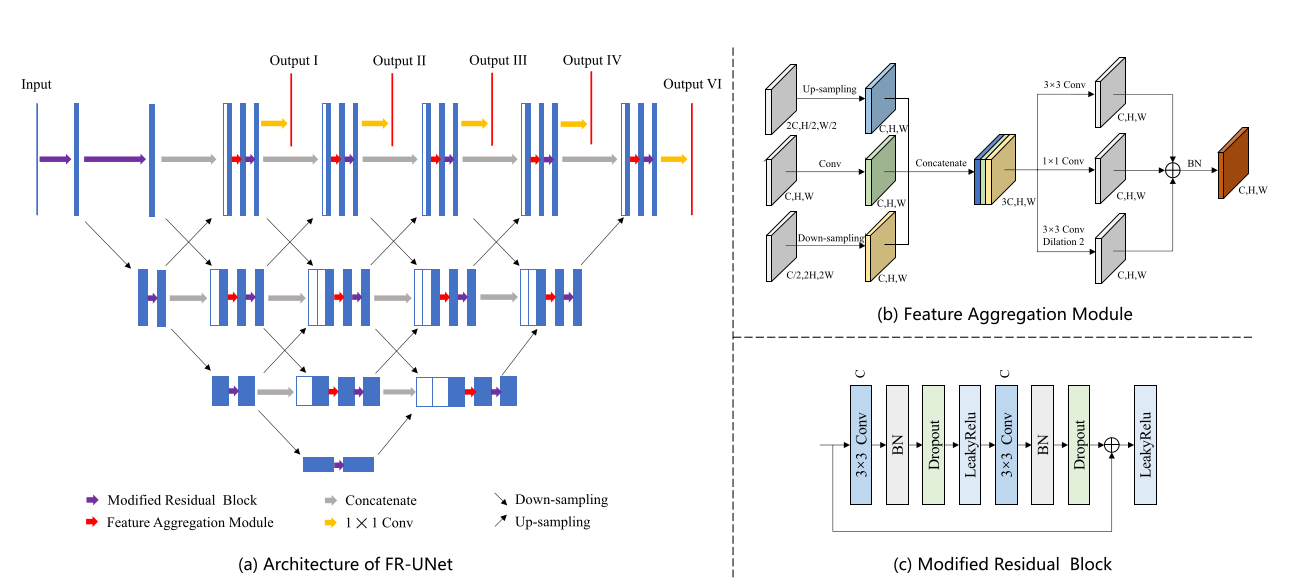

In [ ]:
model = FR_UNet(num_classes=1, num_channels=1).to('cuda')
torchsummary.summary(model, input_size=(1,224,224))

In [8]:
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

train_iou_history = []
val_iou_history = []

device = torch.device('cuda')

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
logs = wandb.init(project="FR_Unet model")

best_acc = 0

num_epochs = 100 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        for images, masks, eye_masks in data:
            images = images.cuda()
            masks = masks.cuda()
            
            optimizer.zero_grad()
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    acc, se, sp, F1, pr, AUC_ROC, dice, iou = evaluate(model, val_loader, num_classes=2)
    logs.log({
        "acc": acc,
        "sensitivity": se,
        "specificity": sp,
        "F1-score": F1,
        "AUC_ROC": AUC_ROC,
        "Dice": dice,
        "epoch": epoch,
        "IOU": iou
    })
    if best_acc < acc:
        best_acc = acc
        print(f"Best accuracy attained: {best_acc*100:.4f}%")
        torch.save(model.state_dict(),"FR_UNet_model.pth")
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {acc*100:.4f}%, IOU: {iou}')

wandb: Currently logged in as: battulasaikiran2002. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.75s/it]


Best accuracy attained: 41.2062%
Epoch [1/100], Loss: 77.6042, Accuracy: 41.2062%, IOU: 0.20355346692459925


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Best accuracy attained: 93.1899%
Epoch [2/100], Loss: 40.8967, Accuracy: 93.1899%, IOU: 0.5134115863414038


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Best accuracy attained: 93.2400%
Epoch [3/100], Loss: 33.8800, Accuracy: 93.2400%, IOU: 0.4694529171855677


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Best accuracy attained: 94.1939%
Epoch [4/100], Loss: 30.5637, Accuracy: 94.1939%, IOU: 0.5452997331108366


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Best accuracy attained: 94.7278%
Epoch [5/100], Loss: 29.2906, Accuracy: 94.7278%, IOU: 0.5627792146943864


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [6/100], Loss: 27.6396, Accuracy: 94.6785%, IOU: 0.5885106452873775


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Best accuracy attained: 94.8979%
Epoch [7/100], Loss: 26.5352, Accuracy: 94.8979%, IOU: 0.6001036995933169


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Epoch [8/100], Loss: 25.9523, Accuracy: 94.7886%, IOU: 0.5725357323884964


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Best accuracy attained: 95.0077%
Epoch [9/100], Loss: 25.4047, Accuracy: 95.0077%, IOU: 0.6078854898611704


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Epoch [10/100], Loss: 24.8814, Accuracy: 94.9524%, IOU: 0.6131926251309259


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Best accuracy attained: 95.1994%
Epoch [11/100], Loss: 24.5489, Accuracy: 95.1994%, IOU: 0.6173214343332109


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [12/100], Loss: 24.1292, Accuracy: 94.5564%, IOU: 0.5633678713015148


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Epoch [13/100], Loss: 23.7541, Accuracy: 95.1088%, IOU: 0.5940680843024027


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [14/100], Loss: 23.0852, Accuracy: 95.0743%, IOU: 0.5994503276333922


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Epoch [15/100], Loss: 23.1541, Accuracy: 94.8407%, IOU: 0.5923449089129765


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Best accuracy attained: 95.3136%
Epoch [16/100], Loss: 22.5226, Accuracy: 95.3136%, IOU: 0.6257197079204377


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [17/100], Loss: 22.3800, Accuracy: 95.2560%, IOU: 0.6397779246880895


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Best accuracy attained: 95.3448%
Epoch [18/100], Loss: 22.0862, Accuracy: 95.3448%, IOU: 0.6333291524932498


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Best accuracy attained: 95.5986%
Epoch [19/100], Loss: 22.0326, Accuracy: 95.5986%, IOU: 0.6587704441377095


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Epoch [20/100], Loss: 21.3712, Accuracy: 95.3052%, IOU: 0.629244819567317


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [21/100], Loss: 21.2124, Accuracy: 95.4945%, IOU: 0.628890773653984


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [22/100], Loss: 21.0238, Accuracy: 95.4099%, IOU: 0.6155468184323538


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [23/100], Loss: 21.0734, Accuracy: 94.7808%, IOU: 0.6094358314360891


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Epoch [24/100], Loss: 21.0817, Accuracy: 95.3376%, IOU: 0.6462340444326401


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [25/100], Loss: 20.6428, Accuracy: 95.2750%, IOU: 0.6267832199377673


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [26/100], Loss: 20.2207, Accuracy: 95.4306%, IOU: 0.6029179997387386


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [27/100], Loss: 20.2257, Accuracy: 95.2483%, IOU: 0.6333990535210996


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]


Epoch [28/100], Loss: 19.8800, Accuracy: 95.3640%, IOU: 0.6289679165397372


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [29/100], Loss: 19.6354, Accuracy: 95.4423%, IOU: 0.6137281847851617


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Best accuracy attained: 95.6158%
Epoch [30/100], Loss: 19.3762, Accuracy: 95.6158%, IOU: 0.6173019546838033


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Best accuracy attained: 95.7349%
Epoch [31/100], Loss: 19.3366, Accuracy: 95.7349%, IOU: 0.6277141988277435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Epoch [32/100], Loss: 19.0226, Accuracy: 95.3834%, IOU: 0.6441028401610397


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Best accuracy attained: 95.7462%
Epoch [33/100], Loss: 18.6854, Accuracy: 95.7462%, IOU: 0.6447676574900036


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Epoch [34/100], Loss: 18.4340, Accuracy: 95.5534%, IOU: 0.6281220054342633


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Epoch [35/100], Loss: 18.2656, Accuracy: 95.7399%, IOU: 0.6249453307617279


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Epoch [36/100], Loss: 18.1387, Accuracy: 95.4513%, IOU: 0.6237134832711447


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Best accuracy attained: 95.9380%
Epoch [37/100], Loss: 17.9114, Accuracy: 95.9380%, IOU: 0.648479116920914


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]


Epoch [38/100], Loss: 17.9513, Accuracy: 95.2765%, IOU: 0.62971878147551


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [39/100], Loss: 18.0485, Accuracy: 95.6518%, IOU: 0.6206281273847535


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [40/100], Loss: 17.5107, Accuracy: 95.9147%, IOU: 0.6862971508786792


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [41/100], Loss: 17.1983, Accuracy: 95.9023%, IOU: 0.6353916215045111


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Best accuracy attained: 96.1136%
Epoch [42/100], Loss: 16.9711, Accuracy: 96.1136%, IOU: 0.6642723827134995


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Epoch [43/100], Loss: 16.7372, Accuracy: 96.0747%, IOU: 0.6493770918675832


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Best accuracy attained: 96.2175%
Epoch [44/100], Loss: 16.6307, Accuracy: 96.2175%, IOU: 0.6577999039774849


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Epoch [45/100], Loss: 16.3091, Accuracy: 95.4575%, IOU: 0.6282801975806555


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [46/100], Loss: 16.5310, Accuracy: 95.6604%, IOU: 0.6216387833867755


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Epoch [47/100], Loss: 16.0166, Accuracy: 96.1125%, IOU: 0.6489931393237341


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [48/100], Loss: 16.1680, Accuracy: 95.5973%, IOU: 0.6641927020180793


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.68s/it]


Best accuracy attained: 96.2259%
Epoch [49/100], Loss: 15.9813, Accuracy: 96.2259%, IOU: 0.6866822668484279


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.82s/it]


Best accuracy attained: 96.3056%
Epoch [50/100], Loss: 15.2104, Accuracy: 96.3056%, IOU: 0.6921020013945444


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Best accuracy attained: 96.4693%
Epoch [51/100], Loss: 14.8666, Accuracy: 96.4693%, IOU: 0.6753401612951642


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.06s/it]


Epoch [52/100], Loss: 14.6748, Accuracy: 96.0365%, IOU: 0.6955042586440132


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Best accuracy attained: 96.9669%
Epoch [53/100], Loss: 15.4941, Accuracy: 96.9669%, IOU: 0.7187111687092554


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.05s/it]


Epoch [54/100], Loss: 14.2279, Accuracy: 96.4595%, IOU: 0.6916562741711026


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [55/100], Loss: 14.1962, Accuracy: 96.3698%, IOU: 0.7171029716730117


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.21s/it]


Epoch [56/100], Loss: 14.8467, Accuracy: 96.1546%, IOU: 0.6598769334100542


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Epoch [57/100], Loss: 14.1475, Accuracy: 96.0427%, IOU: 0.6700664020719982


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [58/100], Loss: 14.1201, Accuracy: 96.0098%, IOU: 0.6512120519365583


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]


Epoch [59/100], Loss: 13.5622, Accuracy: 95.6367%, IOU: 0.6445476360264278


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Epoch [60/100], Loss: 13.4786, Accuracy: 96.3305%, IOU: 0.6975002075944629


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


Epoch [61/100], Loss: 13.5462, Accuracy: 96.3621%, IOU: 0.6610059383369628


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Epoch [62/100], Loss: 12.7803, Accuracy: 96.4590%, IOU: 0.6944616708017531


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Best accuracy attained: 97.3017%
Epoch [63/100], Loss: 12.1712, Accuracy: 97.3017%, IOU: 0.7522819783006396


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Epoch [64/100], Loss: 12.2409, Accuracy: 96.2104%, IOU: 0.6464526569559461


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [65/100], Loss: 12.4218, Accuracy: 96.1491%, IOU: 0.6774298832530067


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.95s/it]


Epoch [66/100], Loss: 12.6165, Accuracy: 96.0037%, IOU: 0.6508444378063792


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Epoch [67/100], Loss: 11.9532, Accuracy: 96.7608%, IOU: 0.6980818473867008


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.73s/it]


Epoch [68/100], Loss: 11.5733, Accuracy: 96.8847%, IOU: 0.7096405456463496


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Epoch [69/100], Loss: 11.5156, Accuracy: 96.7026%, IOU: 0.7373324917895453


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Epoch [70/100], Loss: 11.7489, Accuracy: 96.7927%, IOU: 0.7211943519966942


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.64s/it]


Epoch [71/100], Loss: 11.2338, Accuracy: 96.9648%, IOU: 0.7406975927807036


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.09s/it]


Epoch [72/100], Loss: 11.2532, Accuracy: 96.5304%, IOU: 0.7209559491702489


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Epoch [73/100], Loss: 11.8153, Accuracy: 96.9746%, IOU: 0.7517693285431181


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.63s/it]


Epoch [74/100], Loss: 10.9309, Accuracy: 97.2045%, IOU: 0.7647145200343359


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Epoch [75/100], Loss: 10.6144, Accuracy: 97.1413%, IOU: 0.7627660395134063


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Best accuracy attained: 97.6534%
Epoch [76/100], Loss: 10.3300, Accuracy: 97.6534%, IOU: 0.7739887785343896


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]


Epoch [77/100], Loss: 10.4741, Accuracy: 97.4734%, IOU: 0.7829234062206177


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.73s/it]


Epoch [78/100], Loss: 10.2210, Accuracy: 97.5323%, IOU: 0.7695068640368325


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.65s/it]


Epoch [79/100], Loss: 10.6545, Accuracy: 97.2851%, IOU: 0.7628290244511196


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.64s/it]


Epoch [80/100], Loss: 10.9513, Accuracy: 97.3445%, IOU: 0.7614562179361071


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.64s/it]


Epoch [81/100], Loss: 9.9491, Accuracy: 97.4223%, IOU: 0.7546899645101457


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.67s/it]


Epoch [82/100], Loss: 9.6802, Accuracy: 97.4613%, IOU: 0.7704380512237549


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]


Epoch [83/100], Loss: 9.5541, Accuracy: 97.2791%, IOU: 0.7543586847328004


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.95s/it]


Best accuracy attained: 97.6838%
Epoch [84/100], Loss: 9.9162, Accuracy: 97.6838%, IOU: 0.7721099227666854


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.71s/it]


Epoch [85/100], Loss: 9.5616, Accuracy: 97.3305%, IOU: 0.7686306303455717


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Epoch [86/100], Loss: 9.7188, Accuracy: 97.4291%, IOU: 0.768139826683771


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Epoch [87/100], Loss: 9.2414, Accuracy: 97.3415%, IOU: 0.7865962865806762


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.75s/it]


Best accuracy attained: 97.9124%
Epoch [88/100], Loss: 9.2234, Accuracy: 97.9124%, IOU: 0.7934708464713324


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Epoch [89/100], Loss: 9.1057, Accuracy: 97.3870%, IOU: 0.7654661516348521


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Best accuracy attained: 97.9353%
Epoch [90/100], Loss: 9.3501, Accuracy: 97.9353%, IOU: 0.806251830288342


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [91/100], Loss: 8.7474, Accuracy: 97.6044%, IOU: 0.7924161998998551


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [92/100], Loss: 9.1152, Accuracy: 97.5805%, IOU: 0.7629181830655961


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [93/100], Loss: 9.0518, Accuracy: 97.9243%, IOU: 0.8126664349011012


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.73s/it]


Epoch [94/100], Loss: 8.6148, Accuracy: 97.7632%, IOU: 0.8006252352680479


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [95/100], Loss: 8.4081, Accuracy: 97.2535%, IOU: 0.7750492009378614


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Epoch [96/100], Loss: 8.9266, Accuracy: 97.6293%, IOU: 0.8012685762984412


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Epoch [97/100], Loss: 8.6878, Accuracy: 97.7200%, IOU: 0.8071058361303238


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Epoch [98/100], Loss: 8.3226, Accuracy: 97.8669%, IOU: 0.821798137539909


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Best accuracy attained: 98.0032%
Epoch [99/100], Loss: 8.2721, Accuracy: 98.0032%, IOU: 0.7994919982694444


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Best accuracy attained: 98.1483%
Epoch [100/100], Loss: 8.5930, Accuracy: 98.1483%, IOU: 0.8241053811141423


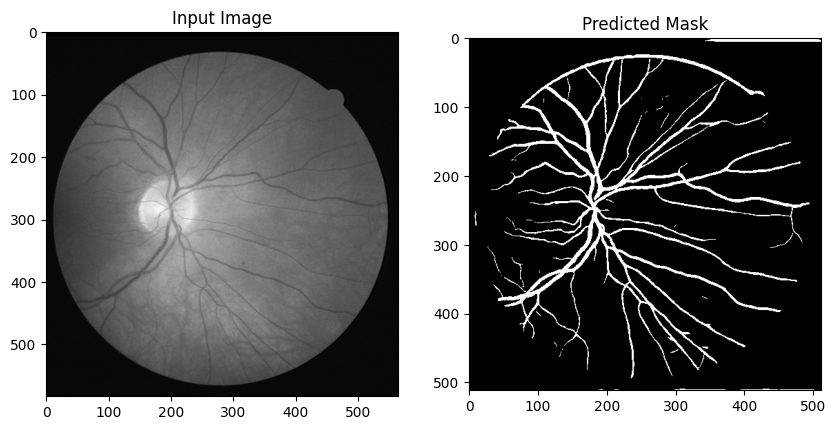

In [9]:
import torch
from torchvision import transforms
from PIL import Image

model = FR_UNet(num_classes=1, num_channels=1).to('cuda')
model.load_state_dict(torch.load("FR_UNet_model.pth"))
model.eval()


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


input_image = Image.open('15_test.tif').convert('L')  
input_tensor = transform(input_image).unsqueeze(0) 


with torch.no_grad():
    output = model(input_tensor.cuda())

output = torch.sigmoid(output)
predicted_mask = (output > 0.5).float()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image,cmap='gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')

plt.show()